# COVID-Vaccines how much 1% matters?

This is the companion notebook to the blog post []().

In [1]:
import os

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm

# Getting the Data

We extracted both COVID cases data and vaccination information from the following on-line public access sources:

- [Data on 14-day notification rate of new COVID-19 cases and deaths (ECDC)](https://www.ecdc.europa.eu/en/publications-data/data-national-14-day-notification-rate-covid-19)
- [COVID-19 Vaccine Tracker (ECDC)](https://www.ecdc.europa.eu/en/publications-data/data-covid-19-vaccination-eu-eea)

# Script configuration

According to the [CDC](https://www.cdc.gov/coronavirus/2019-ncov/vaccines/fully-vaccinated.html) an operatinal definition of fully vaccinated population (FVP) is:


<blockquote cite="https://www.cdc.gov/coronavirus/2019-ncov/vaccines/fully-vaccinated.html">
<i>
In general, people are considered fully vaccinated:

- 2 weeks after their second dose in a 2-dose series, such as the Pfizer or Moderna vaccines, or
- 2 weeks after a single-dose vaccine, such as Johnson & Johnson’s Janssen vaccine
</i>
</blockquote>

In [2]:
# we are interested in the numbers for this week:
WEEK_OF_INTEREST = "2021-W46"

# limit week to be considered fully vaccination (see bellow)
WEEK_FULLY_VACCINATED = "2021-W48"

## ISO Codes

To combine information from both files we'll also need a table with both 2 and 3-letter ISO countries code that we put togheter by copy paste from the Wikipedia.

In [3]:
codes = pd.read_csv("../../../data/iso-codes.csv")

codes.head(5)

,code2,code3
0,AF,AFG
1,AX,ALA
2,AL,ALB
3,DZ,DZA
4,AS,ASM


## Vaccination Data

In [4]:
vd = pd.read_csv("../../../data/covid/data_vaccines.csv")

vd.head(5)

,YearWeekISO,ReportingCountry,Denominator,NumberDosesReceived,NumberDosesExported,FirstDose,FirstDoseRefused,SecondDose,DoseAdditional1,UnknownDose,Region,TargetGroup,Vaccine,Population
0,2020-W53,AT,8901064.0,0.0,0.0,0,NaN,0,0,0,AT,ALL,UNK,8901064
1,2020-W53,AT,8901064.0,61425.0,0.0,5216,NaN,0,0,0,AT,ALL,COM,8901064
2,2020-W53,AT,8901064.0,0.0,0.0,0,NaN,0,0,0,AT,ALL,JANSS,8901064
3,2020-W53,AT,8901064.0,0.0,0.0,0,NaN,0,0,0,AT,ALL,AZ,8901064
4,2020-W53,AT,8901064.0,0.0,0.0,0,NaN,0,0,0,AT,ALL,MOD,8901064


## Death rates

In [5]:
dd = pd.read_csv("../../../data/covid/data_cases.csv")

dd.head(5)

,country,country_code,continent,population,indicator,weekly_count,year_week,rate_14_day,cumulative_count,source
0,Afghanistan,AFG,Asia,38928341,cases,0,2020-01,NaN,0,Epidemic intelligence national data
1,Afghanistan,AFG,Asia,38928341,cases,0,2020-02,0.0,0,Epidemic intelligence national data
2,Afghanistan,AFG,Asia,38928341,cases,0,2020-03,0.0,0,Epidemic intelligence national data
3,Afghanistan,AFG,Asia,38928341,cases,0,2020-04,0.0,0,Epidemic intelligence national data
4,Afghanistan,AFG,Asia,38928341,cases,0,2020-05,0.0,0,Epidemic intelligence national data


# Cleaning and Enriching

In [6]:
# convert the week format to the ISO format
dd['year_week'] = dd['year_week'].str.replace("-", "-W")

#  Data Analysis

## Data Preparation

The original data provides the weekly count of 1st, 2nd and extra doses receive. The number of doses is broken down by age group and country region.

Notice that in this analysis we consider the whole population and not only adults.

In [7]:
# select the rows 2 weeks before the week of interest
ndx0 = vd['YearWeekISO'] <= WEEK_FULLY_VACCINATED

# select the rows with the target group corresponding to the whole population 
ndx1 = (vd['TargetGroup'] == 'ALL')

# select the rows with the target group corresponding to the whole population 
ndx1 = (vd['TargetGroup'] == 'ALL')

# select the rows with the numbers for the whole country
ndx2 = (vd['ReportingCountry'] == vd['Region'])

# select the rows corresponding to the Janssens vaccine
ndx3 = (vd['Vaccine'] == "JANSS")

In [8]:
# sum of 2nd doses for all vaccines
vd1 = vd[ndx0 & ndx1 & ndx2][['ReportingCountry', 'SecondDose']]
g1 = vd1.groupby('ReportingCountry').sum()

# sum of 1st doses all vaccines
vd2 = vd[ndx0 & ndx1 & ndx2 & ndx3][['ReportingCountry', 'FirstDose']]
g2 = vd2.groupby('ReportingCountry').sum()

# get the population for each country
vd3 = vd[ndx0 & ndx1 & ndx2][['ReportingCountry', 'Population']]
g3 = vd3.groupby('ReportingCountry').max()

In [9]:
# merges both 1st dose and 2nd dose Janssens in the same data frame
m1 = pd.merge(g1, g2, how="inner", on="ReportingCountry")

# adds the population columns
m2 = pd.merge(m1, g3, how="inner", on="ReportingCountry")

In [10]:
# computes the proportion of fully vaccinated people
m2['vac'] = (m2['FirstDose'] + m2['SecondDose']) / m2['Population']

In [11]:
m2.head()

,SecondDose,FirstDose,Population,vac
ReportingCountry,,,,
AT,5298635,338724,8901064,0.633335
BE,7632530,408445,11522440,0.697853
BG,1355036,429498,6951482,0.256713
CY,559972,21678,888005,0.655008
CZ,5711764,388551,10693939,0.570446


In [12]:
# add the 2-letter coutnry code to the data
dd1 = pd.merge(dd, codes, how="inner", left_on='country_code', right_on="code3")

In [13]:
# gets the 14 days death rates for the week of interest
ndx1 = (dd1['year_week'] == WEEK_OF_INTEREST)
ndx2 = (dd1['indicator'] == "deaths")

dd2 = dd1[ndx1 & ndx2][['code2', 'rate_14_day']]

In [14]:
# sdd the death rate as a column to the previous data set 
m3 = pd.merge(m2, dd2, how="inner", left_on='ReportingCountry', right_on='code2')

In [15]:
# selects only the columns of interest
data = m3[['code2', 'vac', 'rate_14_day', 'Population']]
data.columns = ['country', 'vac', 'death', 'pop']

In [16]:
data.head()

,country,vac,death,pop
0,AT,0.633335,55.049599,8901064
1,BE,0.697853,39.922100,11522440
2,BG,0.256713,312.882922,6951482
3,CY,0.655008,4.504479,888005
4,CZ,0.570446,105.667332,10693939


## Reproducing the Original Chart

First of all we want to reproduce the original chart on Twitter.

In [17]:
data = data.sort_values('vac')

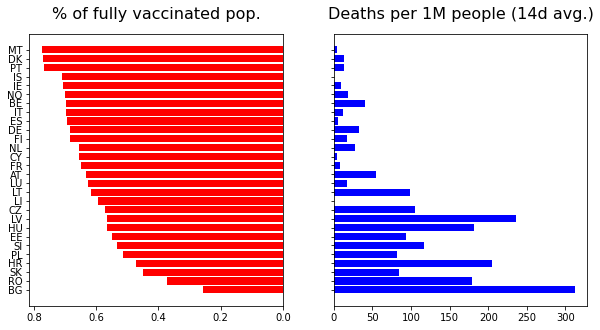

In [18]:
fig, axes = plt.subplots(figsize=(10,5), ncols=2, sharey=True)

axes[0].barh(data['country'], data['vac'], align='center', color="r")
axes[0].set_title("% of fully vaccinated pop.", fontsize=16, pad=15)
axes[1].barh(data['country'], data['death'], align='center', color="b")
axes[1].set_title("Deaths per 1M people (14d avg.)", fontsize=16, pad=15)

axes[0].invert_xaxis() 

plt.savefig("../../images/covid_vaccination/covid_vaccination-fig_1.png")

A quick inspection of the chart reveals an overall agreement with the original chart.

Note that the % of FVP is lower as we consider the whole population and not only the adult one.

## Quantifying the correlation between _PFV_ vs _Death rate_

Now we want to plot FVP against death rate to investigate the possible correlation between those two quantities.

In [19]:
def plot_chart(data, line=None, fname=None):
    fig, ax = plt.subplots()

    ax.set_xlabel('Percentage of vaccinated population')
    ax.set_ylabel('Deaths per 100000 people\n(14 days average)')
    ax.legend()

    sns.scatterplot(x='vac', y='death', data=data, ax=ax)
    
    for _, row in data.iterrows():
        ax.text(row['vac'] - 0.03, row['death'] + 0.1, row['country'])

    if line is not None:
        sns.lineplot(x='x', y='y', data=line)
        
    fig.set_size_inches(8, 6)
    
    plt.title("EU Countries")

    if fname:
        plt.savefig(os.path.join("../../images/covid_vaccination", fname))
        
    plt.show()
    


No handles with labels found to put in legend.


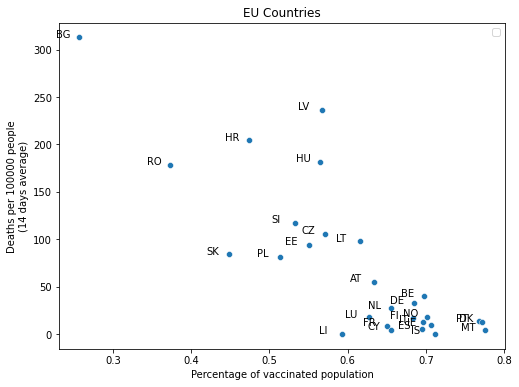

In [20]:
plot_chart(data)

Lets compute and visualize the linear regression (LR) between the two variables to quantify the suspected correlation:

In [21]:
# get the variables in the right shape
X = np.array(data['vac']).reshape(-1, 1)
Y = np.array(data['death']).reshape(-1, 1)

X2 = sm.add_constant(X)
est = sm.OLS(Y, X2)
est2 = est.fit()

In [22]:
(b, m) = est2.params

In [23]:
print("Intercept: %.2f" % b)
print("Slope:     %.2f" % m)

Intercept: 420.16
Slope:     -570.33


No handles with labels found to put in legend.


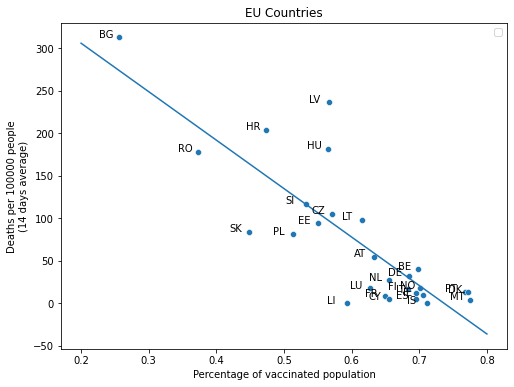

In [24]:
# make prediction for the full domain of the X variable
XX = np.linspace(0.2, 0.8, 10).reshape(-1, 1)
YY_pred = XX * m + b

line = pd.DataFrame({'x': XX[:,0], 'y': YY_pred[:, 0]})

plot_chart(data, line, fname="covid_vaccination-fig_2.png")

## Significance of the Result

The LR negative slope is consistent with our first guess fromt the original Twitter chart of a obvious decrease in deaths with vaccination increase.


Before jumping into conclusions we should take a closer look on the LR results staring with the summary of the parameters and some statistical tests:

In [25]:
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     57.82
Date:                Wed, 08 Dec 2021   Prob (F-statistic):           4.52e-08
Time:                        16:28:18   Log-Likelihood:                -146.61
No. Observations:                  28   AIC:                             297.2
Df Residuals:                      26   BIC:                             299.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        420.1577     46.851      8.968      0.0

We can check how each data point compares with the confidence interval of the LR prediction:

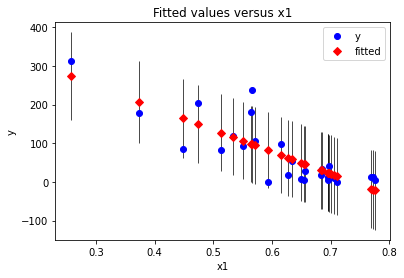

In [26]:
fig = sm.graphics.plot_fit(est2, "x1")

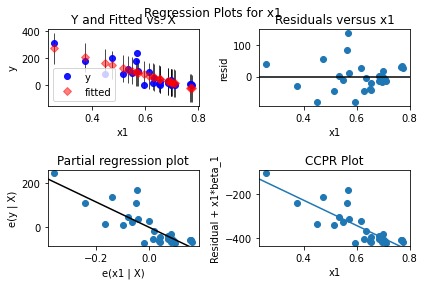

In [27]:
fig = sm.graphics.plot_regress_exog(est2, "x1")

An, finally, check the normality of the residuals looking at the `qqplot`:

/home/jcruz/VE/ds/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


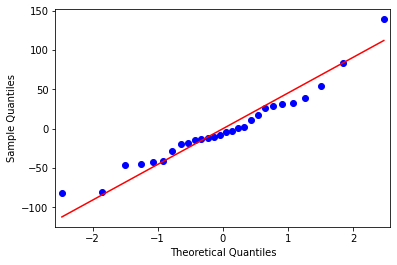

In [28]:
fig = sm.qqplot(est2.resid, stats.t, distargs=(4,), line="s")

At this point we should remind ourselves the assumptions that need to be verified when using LR to take conclusions about the data:

__All observations are independent__

Although cross border and regional effects could challenge this assumption, let's believe that those effects are small enough to be ignored.

__The relationship between the variables we are analysing is linear__

Of course FVP can't go below 0 or above 100, however the linearity should hold at least locally.

__The errors between the prediction and the real values are normally distributed__

The errors don't fall straight in the `QQ plot`, however they don't seem hugely skwed either...

__The errors are homoscedastic, i.e., the error variance doesn't change much along the line__

Again, the error variance is not constant, from the initial plot we can see that countries in the lower PFVP vary greatly in death rate and much more than countries in the higher PFVP.

## Conclusion

All things considered, I wouldn't rely on this LR for a rigorous quantification of the vaccination percentage effect. However, our goal here is to get a rough estimate of the relationship between PFVP and death rate. So, this LR should be enough to support it.

# Compute the absolute decrease in deaths per vaccination %

In the LR above the parameter `m` corresponds to the slope of the line for each 100% of vaccinated population. Thus, we need to divide by 100 to get the variation in number of deaths (14 days average) for each 1% 

In [29]:
m1 = m / 100.0

Once we get an estimate of the slope we can extrapolate to the full population:

In [30]:
eu_pop = data['pop'].sum()

print("Europe population: %d" % eu_pop)

Europe population: 432044223


Our estimate for the absolute change in weekly deaths for the whole population for each 1% of FVP is:

In [34]:
(eu_pop/10**6 * m1) / 7

-352.0102760918289

Finally we generate a chart to illustrate the estimated decrease in deaths for 1% increase in vaccinated population.

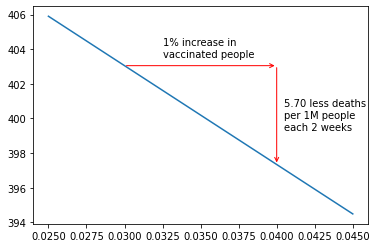

In [36]:
def arrow(plt, x1, y1, x2, y2):
    plt.annotate("", xy=(x1, y1),     xycoords='data',
                     xytext=(x2, y2), textcoords='data',
                     arrowprops=dict(arrowstyle="->",
                                     connectionstyle="arc3",
                                     color='r'))

x1, x2 = (0.03, 0.04)
y1, y2 = (x1 * m + b, x2 * m + b)

dx = 0.01
dy = 0.01

XX = np.linspace(0.025, 0.045, 10)
YY = XX * m + b

plt.plot(XX, YY)

arrow(plt, x2, y1, x1, y1)
arrow(plt, x2, y2, x2, y1)

plt.text(x1 + 0.0025, y1+0.5, "1% increase in\nvaccinated people")
plt.text(x2 + 0.0005, y2+2, "%1.2f less deaths\nper 1M people\neach 2 weeks" % (-0.01 * m))

plt.savefig("../../images/covid_vaccination/covid_vaccination-fig_3.png")

plt.show()